# **Deep Learning NB4: BiDirectional GRUs**

#### Final model compared from the notebook
* MODEL 1

#### Overview
* GRU for text regression
* Split this data set into two sets - one for training our DL model, and one for evaluation  
* Use Keras to create GRU with multiple layers. We will train this model on both CPU environments  
* Evaluate model performance by comparing training and validation scores


---
## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from multiprocessing import cpu_count
print(cpu_count())

16


In [2]:
# %pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential

2023-05-24 15:18:16.396676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 15:18:19.869212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-24 15:18:19.869357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [4]:
tf.config.list_physical_devices()

2023-05-24 15:18:22.303319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-24 15:18:22.303368: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-24 15:18:22.303401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-essay-grading): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

-----
## Importing Data

In [5]:
df_proc=pd.read_csv('../00_gcp_data/preprocessed-essay.csv')
# df_proc.head()

In [6]:
pd.options.display.max_colwidth=None
df_proc[['corrected_text','lemmatized_text']].sample(2)

,corrected_text,lemmatized_text
936,successful people keep study new careers leaning new tasks order became even wealthier get bored job daily ralph emerson states never grow try something new already know meaning people expand knowledge already know never accomplish became successful life however willing expand horizons break comfort zone grow achieve higher goals trying something new already mastered help people grow lead people live real experiences provide opportunities break comfort zone star people learn opportunities opportunities provide people open learn new things grow instance working maritime salad place two years first year learned work stations really good year realized time expand knowledge also ask raise became valid trainer store stations teach new workers assist task correct way paying better shows would open learn trainer store would paying well today capable try something new offer better opportunities order grow rather getting stuck place without trying achieve higher goals moreover desire try different things make people live many wonderful experiences people never expand horizons never experiences adventures life offer instance last summer went campus university get information careers interested meet wonderful students schools learned computer science teachers provided information requirements get university different classes take order get degree computer sciences also practice several methods create graphs draw computers since visited place got convince study computer science future experience never forget realized skills study career major would never notice could study computer science coming learning new things lead live learn experiences help people grow future seen better try something new people explore experiences never forget learn new things became even successful lives people right never stop learning get new skills prepared whatever want accomplish change routine whole world willing keep learning despite mastered something already professionals wealthier society,successful people keep study new career lean new task order become even wealthier get bore job daily ralph emerson state never grow try something new already know meaning people expand knowledge already know never accomplish become successful life however willing expand horizon break comfort zone grow achieve high goal try something new already master help people grow lead people live real experience provide opportunity break comfort zone star people learn opportunity opportunity provide people open learn new thing grow instance work maritime salad place two year first year learn work station really good year realize time expand knowledge also ask raise become valid trainer store station teach new worker assist task correct way pay well show would open learn trainer store would pay well today capable try something new offer well opportunity order grow rather get stuck place without try achieve high goal moreover desire try different thing make people live many wonderful experience people never expand horizon never experience adventure life offer instance last summer go campus university get information career interested meet wonderful student school learn computer science teacher provide information requirement get university different class take order get degree computer science also practice several method create graph draw computer since visit place get convince study computer science future experience never forget realize skill study career major would never notice could study computer science come learn new thing lead live learn experience help people grow future see well try something new people explore experience never forget learn new thing become even successful life people right never stop learn get new skill prepared whatever want accomplish change routine whole world willing keep learn despite master something already professional wealthier society
162,students benefited attend classes home online video conferencing conc

### Setting variables

In [7]:
## Setting text and target variables

textVar=df_proc['lemmatized_text']
targetVar=df_proc[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

----
## Model Parameters

In [8]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our GRU layer
gru_dims = 64

# Training parameters. Here we specify the training of the net will use N examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set N times
num_epochs = 30

# Prepossessing parameters
# We will input the first 1000 words of every essay (and pad out with nulls if a essay review is <1000 words
# We will also build our model using the most frequent 7000 words in our essay 'dictionary'
sequence_length = 1000
max_features = 7000

#Specify the number of classes to predict
num_classes = 6

In [ ]:
## Adding a custom loss function
def mcrmse(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

----
## Text Preprocessing

### Tokenize the data and pad sequences

In [9]:
X = textVar.values
Y = targetVar

train_samples, test_samples, train_targets, test_targets = train_test_split(X,Y, test_size = 0.20, random_state = 1010)

In [10]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_targets.shape)
print(test_samples.shape,test_targets.shape)

(3128,) (3128, 6)
(783,) (783, 6)


In [11]:
# A TextVectorization layer is created with the specified parameters
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

# The train_samples tensor is converted into a TensorFlow Dataset 
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)

# The TextVectorization layer is adapted to the dataset text_ds. 
# This process analyzes the text data in text_ds and builds the vocabulary of the vectorizer based on the observed tokens.
vectorizer.adapt(text_ds)

2023-05-24 15:18:22.722142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'student',
 'people',
 'school',
 'work',
 'get',
 'make',
 'time',
 'want',
 'good',
 'help',
 'like',
 'life',
 'thing',
 'would',
 'think',
 'class',
 'one',
 'well']

In [13]:
vectorizer

### Convert our list of strings data to Numpy arrays of integer indices

In [14]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

Y_train = np.array(train_targets)
Y_test = np.array(test_targets)

In [15]:
X_train.shape

(3128, 1000)

In [16]:
Y_train.shape

(3128, 6)

### Load a pretrained vector space model - GLOVE

In [17]:
embeddings_index = {}

glove_dir = '../00_gcp_data/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6638 words (362 misses)


In [19]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79618001,  0.56779999, -0.96452999, ..., -0.28637001,
         0.54822999, -0.33597001],
       ...,
       [-0.01211   ,  0.001921  , -0.26157999, ...,  0.039627  ,
        -0.12142   , -0.44775   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Load the pre-trained word embeddings matrix into an Embedding layer
We will keep embeddings static with **trainable=False**

In [20]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

----
## MODEL 1: Bi-GRU Model with Pooling

Bidirectional GRUs / LSTMs train two instead of one GRUs / LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This provides additional context to the network and result in faster and fuller learning of the sentense / language model.

The goal is to predict one value per timestep given the full sequence provided as input. This requires that the GRUs / LSTMs hidden layer returns a sequence of values (one per timestep) rather than a single value for the whole input sequence (return_sequences=True)

In [22]:
inputs = Input(shape=(sequence_length, ))

x = Embedding(num_tokens, embedding_dim, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)
flatten_1 = Flatten()(x)

# Create a concatenation of GlobalAveragePooling1D and GlobalMaxPooling1D layers
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concatenated = concatenate([avg_pool, max_pool])
x = Dense(128, activation = 'relu')(concatenated)
x = BatchNormalization()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(6, activation = 'linear')(x)

model_gru_1 = Model(inputs=inputs, outputs=outputs)
model_gru_1.compile(loss = mcrmse, optimizer='adam', metrics = mcrmse)

print(model_gru_1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1000, 100)    700200      ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 1000, 100)   0           ['embedding_1[0][0]']            
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 1000, 128)    63744       ['spatial_dropout1d[0][0]']  

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
svg_image=SVG(model_to_dot(model_gru_1, show_shapes=True, dpi=80).create(prog='dot', format='svg'))
svg_image

with open("bigru_1.svg", "w") as f:
    f.write(svg_image.data)

### Training the model

In [23]:
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_mcrmse', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_mcrmse',  mode="min", min_delta = 0, patience = 25,verbose = 1)

filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun"
checkpoint = ModelCheckpoint(filepath, monitor='val_mcrmse',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE
callbacks = [reduce_lr,earlystop,checkpoint]

t1 = time.time()
model_gru_1_history_rerun = model_gru_1.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=40,
                    validation_split=0.2,
                    callbacks = callbacks,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 3.2321 - mcrmse: 3.2279
Epoch 1: val_mcrmse improved from inf to 2.99132, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 45s 969ms/step - loss: 3.2321 - mcrmse: 3.2279 - val_loss: 2.9911 - val_mcrmse: 2.9913 - lr: 0.0010
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 3.0446 - mcrmse: 3.0469
Epoch 2: val_mcrmse improved from 2.99132 to 2.94916, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 944ms/step - loss: 3.0446 - mcrmse: 3.0469 - val_loss: 2.9490 - val_mcrmse: 2.9492 - lr: 0.0010
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 2.8498 - mcrmse: 2.8448
Epoch 3: val_mcrmse improved from 2.94916 to 2.77063, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 944ms/step - loss: 2.8498 - mcrmse: 2.8448 - val_loss: 2.7703 - val_mcrmse: 2.7706 - lr: 0.0010
Epoch 4/40
40/40 [==============================] - ETA: 0s - loss: 2.5555 - mcrmse: 2.5482
Epoch 4: val_mcrmse improved from 2.77063 to 2.38328, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 39s 985ms/step - loss: 2.5555 - mcrmse: 2.5482 - val_loss: 2.3827 - val_mcrmse: 2.3833 - lr: 0.0010
Epoch 5/40
40/40 [==============================] - ETA: 0s - loss: 2.1281 - mcrmse: 2.1208
Epoch 5: val_mcrmse improved from 2.38328 to 2.01852, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 38s 965ms/step - loss: 2.1281 - mcrmse: 2.1208 - val_loss: 2.0184 - val_mcrmse: 2.0185 - lr: 0.0010
Epoch 6/40
40/40 [==============================] - ETA: 0s - loss: 1.5803 - mcrmse: 1.5722
Epoch 6: val_mcrmse improved from 2.01852 to 1.58208, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 923ms/step - loss: 1.5803 - mcrmse: 1.5722 - val_loss: 1.5818 - val_mcrmse: 1.5821 - lr: 0.0010
Epoch 7/40
40/40 [==============================] - ETA: 0s - loss: 1.0112 - mcrmse: 1.0078
Epoch 7: val_mcrmse improved from 1.58208 to 0.97781, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 932ms/step - loss: 1.0112 - mcrmse: 1.0078 - val_loss: 0.9774 - val_mcrmse: 0.9778 - lr: 0.0010
Epoch 8/40
40/40 [==============================] - ETA: 0s - loss: 0.6799 - mcrmse: 0.6770
Epoch 8: val_mcrmse improved from 0.97781 to 0.70069, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 36s 918ms/step - loss: 0.6799 - mcrmse: 0.6770 - val_loss: 0.7013 - val_mcrmse: 0.7007 - lr: 0.0010
Epoch 9/40
40/40 [==============================] - ETA: 0s - loss: 0.6055 - mcrmse: 0.6094
Epoch 9: val_mcrmse improved from 0.70069 to 0.63949, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 36s 918ms/step - loss: 0.6055 - mcrmse: 0.6094 - val_loss: 0.6400 - val_mcrmse: 0.6395 - lr: 0.0010
Epoch 10/40
40/40 [==============================] - ETA: 0s - loss: 0.5769 - mcrmse: 0.5795
Epoch 10: val_mcrmse improved from 0.63949 to 0.61483, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 36s 920ms/step - loss: 0.5769 - mcrmse: 0.5795 - val_loss: 0.6157 - val_mcrmse: 0.6148 - lr: 0.0010
Epoch 11/40
40/40 [==============================] - ETA: 0s - loss: 0.5628 - mcrmse: 0.5655
Epoch 11: val_mcrmse did not improve from 0.61483
40/40 [==============================] - 28s 700ms/step - loss: 0.5628 - mcrmse: 0.5655 - val_loss: 0.6209 - val_mcrmse: 0.6203 - lr: 0.0010
Epoch 12/40
40/40 [==============================] - ETA: 0s - loss: 0.5535 - mcrmse: 0.5611
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_mcrmse did not improve from 0.61483
40/40 [==============================] - 25s 620ms/step - loss: 0.5535 - mcrmse: 0.5611 - val_loss: 0.6350 - val_mcrmse: 0.6346 - lr: 0.0010
Epoch 13/40
40/40 [==============================] - ETA: 0s - loss: 0.5333 - mcrmse: 0.5333
Epoch 13: val_mcrmse did not improve from 0.61483
40/40 [==============================] - 25s 618ms/step - loss: 0.5333

INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 943ms/step - loss: 0.5181 - mcrmse: 0.5159 - val_loss: 0.5959 - val_mcrmse: 0.5955 - lr: 2.5000e-04
Epoch 15/40
40/40 [==============================] - ETA: 0s - loss: 0.5140 - mcrmse: 0.5206
Epoch 15: val_mcrmse improved from 0.59553 to 0.59334, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 943ms/step - loss: 0.5140 - mcrmse: 0.5206 - val_loss: 0.5936 - val_mcrmse: 0.5933 - lr: 2.5000e-04
Epoch 16/40
40/40 [==============================] - ETA: 0s - loss: 0.5131 - mcrmse: 0.5141
Epoch 16: val_mcrmse did not improve from 0.59334
40/40 [==============================] - 25s 618ms/step - loss: 0.5131 - mcrmse: 0.5141 - val_loss: 0.5980 - val_mcrmse: 0.5978 - lr: 2.5000e-04
Epoch 17/40
40/40 [==============================] - ETA: 0s - loss: 0.5120 - mcrmse: 0.5214
Epoch 17: val_mcrmse improved from 0.59334 to 0.59209, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 933ms/step - loss: 0.5120 - mcrmse: 0.5214 - val_loss: 0.5925 - val_mcrmse: 0.5921 - lr: 2.5000e-04
Epoch 18/40
40/40 [==============================] - ETA: 0s - loss: 0.5091 - mcrmse: 0.5122
Epoch 18: val_mcrmse improved from 0.59209 to 0.58336, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 924ms/step - loss: 0.5091 - mcrmse: 0.5122 - val_loss: 0.5839 - val_mcrmse: 0.5834 - lr: 2.5000e-04
Epoch 19/40
40/40 [==============================] - ETA: 0s - loss: 0.5063 - mcrmse: 0.5094
Epoch 19: val_mcrmse did not improve from 0.58336
40/40 [==============================] - 24s 611ms/step - loss: 0.5063 - mcrmse: 0.5094 - val_loss: 0.5960 - val_mcrmse: 0.5954 - lr: 2.5000e-04
Epoch 20/40
40/40 [==============================] - ETA: 0s - loss: 0.4965 - mcrmse: 0.4996
Epoch 20: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 20: val_mcrmse did not improve from 0.58336
40/40 [==============================] - 24s 610ms/step - loss: 0.4965 - mcrmse: 0.4996 - val_loss: 0.5986 - val_mcrmse: 0.5981 - lr: 2.5000e-04
Epoch 21/40
40/40 [==============================] - ETA: 0s - loss: 0.4983 - mcrmse: 0.5007
Epoch 21: val_mcrmse did not improve from 0.58336
40/40 [==============================] - 24s 610ms/step - l

INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 37s 930ms/step - loss: 0.4909 - mcrmse: 0.4976 - val_loss: 0.5837 - val_mcrmse: 0.5833 - lr: 3.8147e-09
Epoch 36/40
40/40 [==============================] - ETA: 0s - loss: 0.4981 - mcrmse: 0.4997
Epoch 36: val_mcrmse improved from 0.58335 to 0.58273, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_rerun/assets


40/40 [==============================] - 36s 919ms/step - loss: 0.4981 - mcrmse: 0.4997 - val_loss: 0.5831 - val_mcrmse: 0.5827 - lr: 3.8147e-09
Epoch 37/40
40/40 [==============================] - ETA: 0s - loss: 0.4908 - mcrmse: 0.4916
Epoch 37: val_mcrmse did not improve from 0.58273
40/40 [==============================] - 24s 610ms/step - loss: 0.4908 - mcrmse: 0.4916 - val_loss: 0.5834 - val_mcrmse: 0.5830 - lr: 3.8147e-09
Epoch 38/40
40/40 [==============================] - ETA: 0s - loss: 0.4979 - mcrmse: 0.4971
Epoch 38: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.

Epoch 38: val_mcrmse did not improve from 0.58273
40/40 [==============================] - 25s 615ms/step - loss: 0.4979 - mcrmse: 0.4971 - val_loss: 0.5836 - val_mcrmse: 0.5832 - lr: 3.8147e-09
Epoch 39/40
40/40 [==============================] - ETA: 0s - loss: 0.4948 - mcrmse: 0.4968
Epoch 39: val_mcrmse did not improve from 0.58273
40/40 [==============================] - 24s 611ms/step - 

In [24]:
model_gru_1_history_rerun.history.keys()

dict_keys(['loss', 'mcrmse', 'val_loss', 'val_mcrmse', 'lr'])

In [70]:
import matplotlib.ticker as ticker
def plot_train_rmse(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['mcrmse']) + 1)
    
    fig, ax1 = plt.subplots(figsize=(13, 8))

    # ax1.subplots(1,1,figsize=(13,8))
    ax1.plot(epochs, h['mcrmse'], 'r', label='Training RMSE')
    ax1.plot(epochs, h['val_mcrmse'], 'g', label='Validation RMSE')
    ax1.set_ylabel('RMSEs')
    ax1.set_xlabel('Epochs')

    
    ax2 = ax1.twinx()
    ax2.plot(epochs, h['lr'], 'o', label='Learning Rate')
    ax2.set_ylabel('Learning Rate')

    # Set the y-axis formatter for ax2 to exponential notation
    ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax2.yaxis.offsetText.set_visible(True)

    fig.suptitle('Training and Validation RMSE, along with Learning Rates')
    ax1.set_title('BiDirectional GRUs')

    ax1.legend(loc='lower left')
    ax2.legend(loc='upper right', bbox_to_anchor=(2, 2))
    plt.legend()
    plt.show()

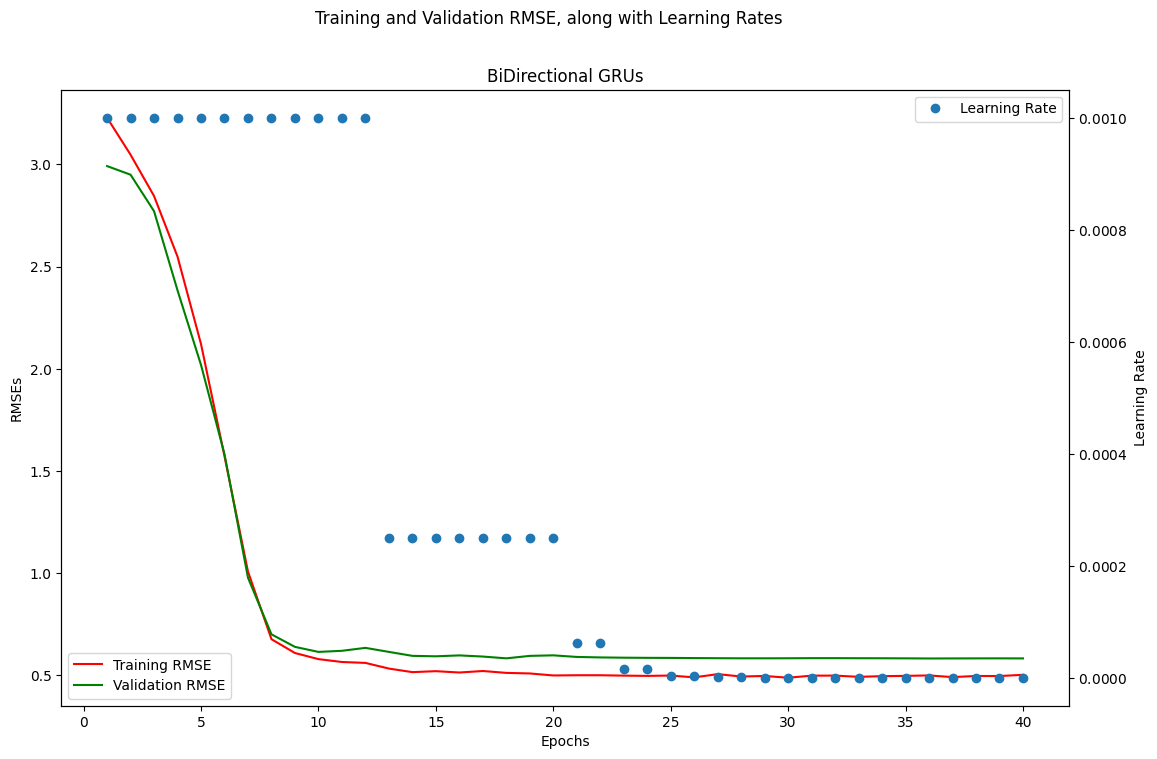

In [71]:
plot_train_rmse(model_gru_1_history_rerun)

In [160]:
model_gru_1.evaluate(X_test, Y_test)

25/25 [==============================] - 4s 179ms/step - loss: 0.5978 - mcrmse: 0.5958


[0.5978489518165588, 0.5958216190338135]

----
## MODEL 2: Removing Pooling

In [23]:
inputs = Input(shape=(sequence_length, ))

x = Embedding(num_tokens, embedding_dim, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)
x = Flatten()(x)

x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(6, activation = 'linear')(x)

model_gru_2 = Model(inputs=inputs, outputs=outputs)
model_gru_2.compile(loss = mcrmse, optimizer='adam', metrics = mcrmse)

print(model_gru_2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1000, 100)         700200    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 1000, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 1000, 128)        63744     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 128000)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               1638

In [25]:
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_mcrmse', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_mcrmse',  mode="min", min_delta = 0, patience = 25,verbose = 1)

filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/gru_glove_weights_best_2"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE
callbacks = [reduce_lr,earlystop,checkpoint]

t1 = time.time()
model_gru_2_history = model_gru_2.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks,
                    verbose=1)
t2 = time.time()
print("GRU Glove model train time = %d seconds" %(t2-t1))

Epoch 1/30
40/40 [==============================] - 37s 803ms/step - loss: 3.1797 - mcrmse: 3.1688 - val_loss: 2.6814 - val_mcrmse: 2.6801 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 35s 871ms/step - loss: 3.0113 - mcrmse: 3.0039 - val_loss: 2.6151 - val_mcrmse: 2.6159 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 30s 736ms/step - loss: 2.8218 - mcrmse: 2.8182 - val_loss: 2.6055 - val_mcrmse: 2.6067 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 31s 784ms/step - loss: 2.5200 - mcrmse: 2.5178 - val_loss: 2.2531 - val_mcrmse: 2.2544 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - 34s 863ms/step - loss: 2.0877 - mcrmse: 2.0801 - val_loss: 1.9845 - val_mcrmse: 1.9852 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - 33s 836ms/step - loss: 1.5480 - mcrmse: 1.5393 - val_loss: 1.1477 - val_mcrmse: 1.1487 - lr: 0.0010
Epoch 7/30
40/40 [==============================] - 36s 899ms/step - loss: 1.0254 - mcrm

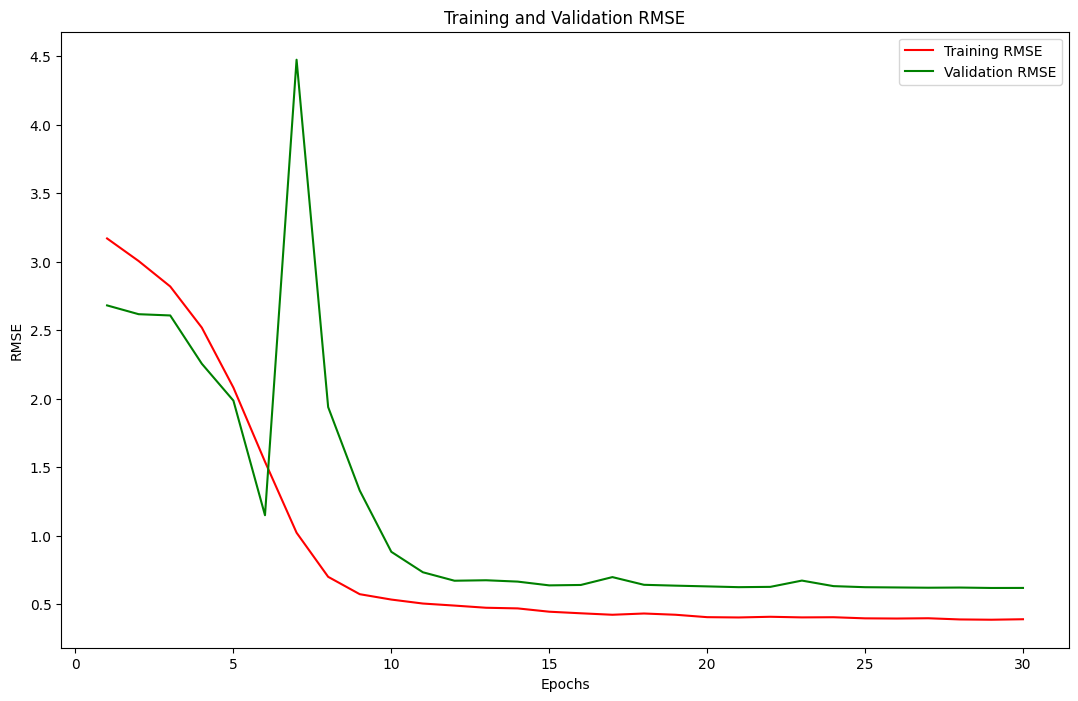

In [28]:
plot_train_rmse(model_gru_2_history)

In [29]:
model_gru_2.evaluate(X_test, Y_test)

25/25 [==============================] - 5s 203ms/step - loss: 0.6299 - mcrmse: 0.6277


[0.6299134492874146, 0.627717912197113]

In [30]:
model_gru_2.save('model_gru_2.h5')

In [32]:
def save_epochs(history):
    h = history.history
    df = pd.DataFrame({'Epochs':list(range(1, len(h['mcrmse']) + 1)), 'RMSE':list(h['mcrmse'])})
    return df

In [33]:
model_gru_2_epochs_df=save_epochs(model_gru_2_history)
model_gru_2_epochs_df.to_csv('model_gru_2_epochs_df.csv', index=False)